In [1]:
"""Plots the loss of the model & performs basic evaluation.
"""

'Plots the loss of the model & performs basic evaluation.\n'

In [30]:
import pathlib
import torch
from typing import List, Union, Tuple
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.special import inv_boxcox
import pandas as pd
from dataset import SimulationDataset
from model import MLPReg

In [3]:
def plot_loss(
    model_name: str, train_loss: List[float], valid_loss: List[float]
) -> None:
    """Visualizes the loss data of the trained model.

    Args:
        model_name: Name of the trained model.
        train_loss: Loss data generated during training.
        valid_loss: Loss data generated during validation.
    """
    plt.figure(figsize=(12, 7))
    plt.suptitle(model_name + " loss values")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.legend(["Training Loss", "Validation Loss"])
    plt.show()

In [4]:
def txt_to_list(input_path: Union[pathlib.Path, str]) -> List[str]:
    """Loads a .txt file into a list.
    Args:
        input_path: Input path to the txt file.

    Returns:
        List containing data from the .txt file.
    """
    with open(input_path, "r") as f:
        data = f.read().splitlines()
    
    return data

In [120]:
model_name = 'lr_1_e_m4_b_16_e_10000_LeakyReLU_transformed_output_IQR_deeper'

In [121]:
TRAINED_MODEL_PATH = f'./trained_models/{model_name}.pt'
TRAIN_LOSS_PATH = f'./trained_models/{model_name}_training_loss.txt'
VALID_LOSS_PATH = f'./trained_models/{model_name}_validation_loss.txt'

In [122]:
model_name = pathlib.Path(TRAINED_MODEL_PATH).stem
train_loss= txt_to_list(TRAIN_LOSS_PATH)
valid_loss= txt_to_list(VALID_LOSS_PATH)

In [123]:
# Convert str to float & tidy up.
train_loss = [float(el) for el in train_loss]
train_loss = [round(el, 4) for el in train_loss]

valid_loss = [float(el) for el in valid_loss]
valid_loss = [round(el, 4) for el in valid_loss]

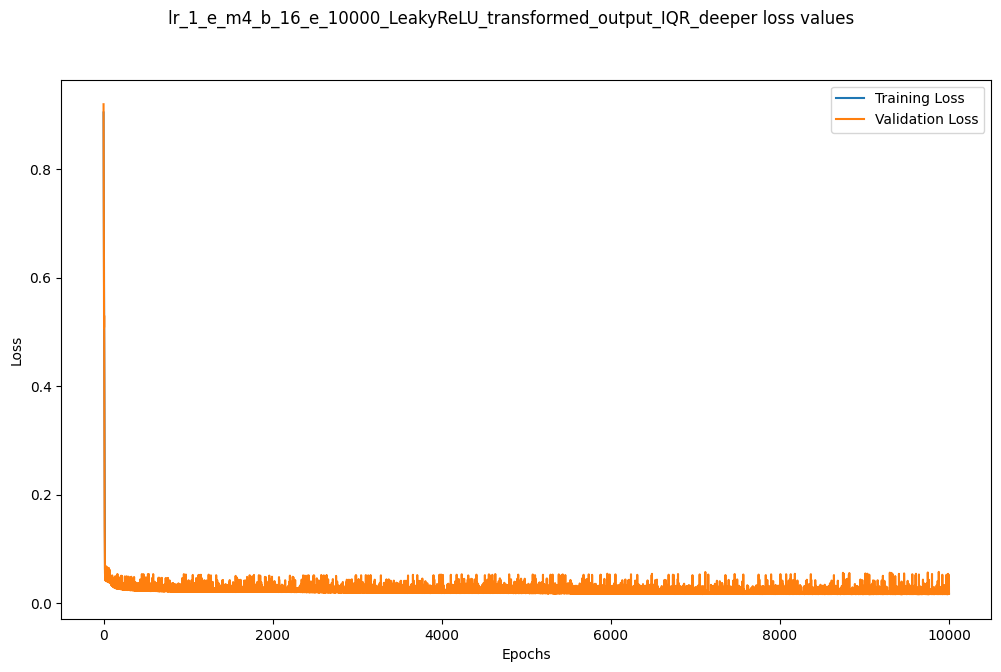

In [124]:
plot_loss(model_name, train_loss, valid_loss)

In [125]:
TRAINED_STATE_DICT_PATH = f'./trained_models/{model_name}_state_dict'

In [126]:
# Set the device & clean the memory.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
torch.cuda.empty_cache()

Device:  cuda:0


In [127]:
# Load the trained model state dictionary.
model = MLPReg()
model.load_state_dict(torch.load(TRAINED_STATE_DICT_PATH))

/tmp/ipykernel_273459/1831910469.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(TRAINED_STATE_DICT_PATH))


<All keys matched successfully>

In [128]:
# Load test dataset.
batch_size = 8
dataset_path = "./data/dataset_test.csv"
features = ["Temperature", "Depth Of Cut", "Feed Rate", "Lenght Of Cut"]
labels = ["Load X", "Load Y"]

test_dataset = SimulationDataset(dataset_path, features, labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [129]:
# BoxCox transformation parameters - relevant for inverse transformation.
lambda_load_x = 0.5219071729291129
lambda_load_y = 0.40813414622179595

In [130]:
# Pre - normalization min and max values of output variables. 
x_load_min = 650.3838414957692
x_load_max = 1831.6845429765622
y_load_min = -0.23301682607607901
y_load_max = 686.0612810310728

In [131]:
# Evaluate the model.
x_load_preds = []
y_load_preds = []
x_load_actuals = []
y_load_actuals = []
for batch_features, batch_labels in test_dataloader:
    outputs = model(batch_features)
    predicted_labels = outputs.detach().numpy()

    for i in range(len(batch_features)):
        features = batch_features[i]
        labels = batch_labels[i]
        predicted = predicted_labels[i]
      
        x_load_pred = predicted[0]
        y_load_pred = predicted[1]
        x_load_actual = labels.numpy()[0]
        y_load_actual = labels.numpy()[1]

        x_load_preds.append(x_load_pred)
        y_load_preds.append(y_load_pred)
        x_load_actuals.append(x_load_actual)
        y_load_actuals.append(y_load_actual)

In [132]:
x_load_preds = np.array(x_load_preds)
y_load_preds = np.array(y_load_preds)
x_load_actuals = np.array(x_load_actuals)
y_load_actuals = np.array(y_load_actuals)

In [133]:
# Scale the predictions and ground truth labels back to nominal range.
x_load_preds = x_load_preds * (x_load_max - x_load_min) + x_load_min
y_load_preds = y_load_preds * (y_load_max - y_load_min) + y_load_min

x_load_actuals = x_load_actuals * (x_load_max - x_load_min) + x_load_min
y_load_actuals = y_load_actuals * (y_load_max - y_load_min) + y_load_min

In [134]:
# Do a reverse of BoxCox transformation.
x_load_preds = inv_boxcox(x_load_preds, lambda_load_x)
y_load_preds = inv_boxcox(y_load_preds, lambda_load_y)

x_load_actuals = inv_boxcox(x_load_actuals, lambda_load_x)
y_load_actuals = inv_boxcox(y_load_actuals, lambda_load_y)

In [135]:
generalization_errors_x = []
generalization_errors_y = []

for i in range(len(x_load_preds)):

        x_load_pred = x_load_preds[i]
        y_load_pred = y_load_preds[i]
        x_load_actual = x_load_actuals[i]
        y_load_actual = y_load_actuals[i]
    
        print("Predicted X Load:,", x_load_pred)
        print("Predicted Y Load:,", y_load_pred)
        print("Actual X Load:,", x_load_actual)
        print("Actual Y Load:,", y_load_actual)

        generalization_error_x = round(abs(x_load_pred - x_load_actual), 4)
        generalization_error_y = round(abs(y_load_pred - y_load_actual), 4)
        print('Error X:', generalization_error_x)
        print('Error Y:', generalization_error_y)
        generalization_errors_x.append(generalization_error_x)
        generalization_errors_y.append(generalization_error_y)

        print("------------------")

Predicted X Load:, 144621.94
Predicted Y Load:, 250185.64
Actual X Load:, 129619.06
Actual Y Load:, 289397.12
Error X: 15002.875
Error Y: 39211.484
------------------
Predicted X Load:, 215725.19
Predicted Y Load:, 724931.3
Actual X Load:, 215085.08
Actual Y Load:, 889079.3
Error X: 640.1094
Error Y: 164148.0
------------------
Predicted X Load:, 168718.02
Predicted Y Load:, 784952.0
Actual X Load:, 165754.08
Actual Y Load:, 729717.2
Error X: 2963.9375
Error Y: 55234.81
------------------
Predicted X Load:, 274982.1
Predicted Y Load:, 305703.28
Actual X Load:, 233567.14
Actual Y Load:, 745945.4
Error X: 41414.953
Error Y: 440242.06
------------------
Predicted X Load:, 130811.3
Predicted Y Load:, 320593.9
Actual X Load:, 126634.05
Actual Y Load:, 459437.25
Error X: 4177.25
Error Y: 138843.34
------------------
Predicted X Load:, 170241.81
Predicted Y Load:, 785403.1
Actual X Load:, 166218.06
Actual Y Load:, 739394.25
Error X: 4023.75
Error Y: 46008.875
------------------
Predicted X Lo

In [136]:
generalization_errors_x = np.array(generalization_errors_x)
mae_x = np.sum(generalization_errors_x / np.shape(generalization_errors_x)[0])
mse_x = np.sum(generalization_errors_x**2 / np.shape(generalization_errors_x)[0])
rmse_x = np.sqrt(mse_x)

generalization_errors_y = np.array(generalization_errors_y)
mae_y = np.sum(generalization_errors_y / np.shape(generalization_errors_y)[0])
mse_y = np.sum(generalization_errors_y**2 / np.shape(generalization_errors_y)[0])
rmse_y = np.sqrt(mse_y)

In [137]:
print('Total evaluation metrics - Load X')
print('MAE:', np.round(mae_x, 4))
print('MSE:', np.round(mse_x, 4))
print('RMSE:', np.round(rmse_x, 4))
print('Total evaluation metrics - Load Y')
print('MAE:', np.round(mae_y, 4))
print('MSE:', np.round(mse_y, 4))
print('RMSE:', np.round(rmse_y, 4))

Total evaluation metrics - Load X
MAE: 15697.381
MSE: 1144393000.0
RMSE: 33828.88
Total evaluation metrics - Load Y
MAE: 155567.83
MSE: 55269640000.0
RMSE: 235094.97
